In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics import accuracy_score

import numpy as np
import pickle
import os
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

/Users/nilsgrunefeld/Documents/GitHub/gradient-uncertainty/env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compare_measures(m1, m2, name1, name2, ax=None):
    m1 = m1.flatten()
    m2 = m2.flatten()

    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]
    print(f"Correlation between {name1} and {name2}: {correlation.item():.4f}")

    if ax is not None:
        ax.scatter(m1, m2, alpha=0.5, s=5)
        ax.set_xlabel(name1)
        ax.set_ylabel(name2)
        ax.set_title(f"Correlation: {correlation.item():.4f}")

        z = np.polyfit(m1.numpy(), m2.numpy(), 1)
        p = np.poly1d(z)
        x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
        ax.plot(x_range, p(x_range), "r--", alpha=0.8)

    return correlation.item()

In [3]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.layer_1 = nn.Linear(2, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        logits = self.layer_1(x)
        return F.softmax(logits, dim=1)

    def get_logits(self, x):
        return self.layer_1(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [4]:
class ComplexModel(nn.Module):
    def __init__(self, hidden_size=32, num_classes=3):
        super().__init__()
        self.layer_1 = nn.Linear(2, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, num_classes)
        self.num_classes = num_classes

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        logits = self.layer_2(x)
        return F.softmax(logits, dim=1)

    def get_logits(self, x):
        x = F.relu(self.layer_1(x))
        return self.layer_2(x)

    def parameters_as_vector(self):
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters())

In [5]:
def get_grad_norm(model, loss_fn, x, y):
    model.zero_grad()
    outputs = model(x)
    loss = loss_fn(outputs, y)
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())

    return torch.norm(torch.cat(grads))

In [6]:
def model_to_pyro(model, X, y, prior_precision=0.01):
    """Convert PyTorch model to Pyro model for MCMC."""

    def model_fn():
        n_params = model.count_parameters()
        n_classes = model.num_classes

        # Set up priors on all parameters
        scale = 1.0 / np.sqrt(prior_precision)
        prior = dist.Normal(
            loc=torch.zeros(n_params), scale=scale * torch.ones(n_params)
        ).to_event(1)

        # Sample parameters from prior
        params = pyro.sample("params", prior)

        # Apply parameters to the model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Forward pass through the model
        with torch.no_grad():
            logits = model.get_logits(X)

        # Likelihood for multiclass
        with pyro.plate("data", len(X)):
            obs = pyro.sample("obs", dist.Categorical(logits=logits), obs=y)

        return obs

    return model_fn

In [7]:
def run_mcmc_with_pyro(
    model, X, y, prior_precision=0.01, num_samples=1000, warmup_steps=200
):
    """Run MCMC sampling for the model parameters."""
    pyro_model = model_to_pyro(model, X, y, prior_precision)

    # Pre-training with cross-entropy loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    print("Pre-training model for MCMC initialization...")
    for epoch in range(100):
        logits = model.get_logits(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

    kernel = NUTS(pyro_model)

    print(f"Running NUTS MCMC sampler...")
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run()

    samples = mcmc.get_samples()

    return samples

In [8]:
def pyro_samples_to_matrix(samples):
    """Extract parameter samples from Pyro MCMC results."""
    param_samples = samples["params"]
    return param_samples

In [9]:
class ExperimentSaver:
    def __init__(self, base_dir="saved_experiments/multiclass"):
        self.base_dir = base_dir
        os.makedirs(base_dir, exist_ok=True)

    def save_experiment(self, experiment_data, experiment_name=None):
        """Save experiment data with a unique time-stamped identifier."""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        if experiment_name is None:
            experiment_id = f"exp_{timestamp}"
        else:
            experiment_id = f"{experiment_name}_{timestamp}"

        # Create experiment directory
        exp_dir = os.path.join(self.base_dir, experiment_id)
        os.makedirs(exp_dir, exist_ok=True)

        # Save experiment data
        filepath = os.path.join(exp_dir, "experiment.pkl")
        with open(filepath, "wb") as f:
            pickle.dump(experiment_data, f)

        print(f"Experiment saved as: {experiment_id}")
        print(f"Directory: {exp_dir}")
        return experiment_id, exp_dir

    def load_experiment(self, experiment_id):
        """Load experiment data by identifier."""
        exp_dir = os.path.join(self.base_dir, experiment_id)
        filepath = os.path.join(exp_dir, "experiment.pkl")

        if not os.path.exists(filepath):
            raise FileNotFoundError(
                f"Experiment {experiment_id} not found at {filepath}"
            )

        with open(filepath, "rb") as f:
            experiment_data = pickle.load(f)

        return experiment_data, exp_dir

    def list_experiments(self):
        """List all saved experiments."""
        experiments = []
        for dirname in os.listdir(self.base_dir):
            exp_path = os.path.join(self.base_dir, dirname)
            if os.path.isdir(exp_path):
                # Check if experiment.pkl exists in the directory
                pkl_path = os.path.join(exp_path, "experiment.pkl")
                if os.path.exists(pkl_path):
                    experiments.append(dirname)
        return sorted(experiments)

    def get_experiment_directory(self, experiment_id):
        """Get the directory path for a specific experiment."""
        return os.path.join(self.base_dir, experiment_id)

In [10]:
def train_standard_model(X, y, model_class, model_args=None, epochs=1000, verbose=True):
    """Train a model using standard optimization and return experiment data."""
    if model_args is None:
        model_args = {}

    # Convert to PyTorch tensors
    X = torch.Tensor(X)
    y_numpy = y.astype(np.int64)
    y = torch.LongTensor(y_numpy)

    # Create and train the model
    model = model_class(**model_args)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        logits = model.get_logits(X)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose and (epoch + 1) % (epochs // 10) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Evaluate accuracy
    with torch.no_grad():
        logits = model.get_logits(X)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == y).float().mean()

    if verbose:
        print(f"Accuracy on entire dataset: {accuracy.item():.4f}")

    # Create experiment data
    experiment_data = {
        "type": "standard",
        "model_state_dict": model.state_dict(),
        "model_class": model_class,
        "model_args": model_args,
        "X": X,
        "y": y,
        "accuracy": accuracy.item(),
        "criterion": criterion,
        "mcmc_samples": None,
    }

    return experiment_data

In [11]:
def train_mcmc_model(
    X,
    y,
    model_class,
    model_args=None,
    prior_precision=0.01,
    num_samples=1000,
    warmup_steps=200,
    verbose=True,
):
    """Train a model using MCMC and return experiment data."""
    if model_args is None:
        model_args = {}

    # Convert to PyTorch tensors
    X = torch.Tensor(X)
    y_numpy = y.astype(np.int64)
    y = torch.LongTensor(y_numpy)

    # Create model and run MCMC
    model = model_class(**model_args)
    criterion = nn.CrossEntropyLoss()

    samples = run_mcmc_with_pyro(
        model,
        X,
        y,
        prior_precision=prior_precision,
        num_samples=num_samples,
        warmup_steps=warmup_steps,
    )

    param_samples = pyro_samples_to_matrix(samples)

    # Calculate accuracy using mean of posterior samples
    with torch.no_grad():
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = param_samples.mean(dim=0)[idx : idx + param_size].reshape(
                param.shape
            )
            idx += param_size

        logits = model.get_logits(X)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == y).float().mean()

    if verbose:
        print(f"Accuracy on entire dataset: {accuracy.item():.4f}")

    # Create experiment data
    experiment_data = {
        "type": "mcmc",
        "model_state_dict": model.state_dict(),
        "model_class": model_class,
        "model_args": model_args,
        "X": X,
        "y": y,
        "accuracy": accuracy.item(),
        "criterion": criterion,
        "mcmc_samples": param_samples,
        "prior_precision": prior_precision,
    }

    return experiment_data

In [12]:
def mcmc_predict_with_samples(model, X_test, param_samples):
    """Make predictions using MCMC parameter samples."""
    n_samples = param_samples.shape[0]
    n_test = X_test.shape[0]
    n_classes = model.num_classes

    # Store predictions for each class from all samples
    all_preds = torch.zeros(n_samples, n_test, n_classes)

    # Make predictions for each sample
    for i in range(n_samples):
        # Extract parameters for this sample
        params = param_samples[i]

        # Apply parameters to model
        idx = 0
        for param in model.parameters():
            param_size = param.numel()
            param.data = params[idx : idx + param_size].reshape(param.shape)
            idx += param_size

        # Make predictions
        with torch.no_grad():
            preds = model(X_test)
            all_preds[i] = preds

    # Compute mean and variance
    pred_mean = all_preds.mean(dim=0)
    pred_var = all_preds.var(dim=0)

    # Total predictive uncertainty (sum of variances across all classes)
    total_uncertainty = pred_var.sum(dim=1)

    return pred_mean, pred_var, total_uncertainty

In [13]:
def compute_uncertainty_measures(experiment_data):
    """Compute all uncertainty measures for a given experiment."""
    # Reconstruct model
    model = experiment_data["model_class"](**experiment_data["model_args"])
    model.load_state_dict(experiment_data["model_state_dict"])

    X = experiment_data["X"]
    y = experiment_data["y"]
    criterion = experiment_data["criterion"]
    mcmc_samples = experiment_data["mcmc_samples"]

    # Create grid for uncertainty computation
    x_min, x_max = X[:, 0].min() - 1.5, X[:, 0].max() + 1.5
    y_min, y_max = X[:, 1].min() - 1.5, X[:, 1].max() + 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    n_classes = model.num_classes

    # Get predictions on the grid
    with torch.no_grad():
        grid_probs = model(grid)
        grid_classes = grid_probs.argmax(dim=1).reshape(xx.shape)

    # MCMC predictions if samples are provided
    mcmc_total_uncertainty = None
    if mcmc_samples is not None:
        mcmc_mean, mcmc_var, mcmc_total_uncertainty = mcmc_predict_with_samples(
            model, grid, mcmc_samples
        )
        mcmc_total_uncertainty = mcmc_total_uncertainty.reshape(xx.shape)

    # Compute gradient uncertainties
    gradient_uncertainty_same = torch.zeros(len(grid))
    gradient_uncertainty_alt = torch.zeros(len(grid))

    for i, x in enumerate(grid):
        x_tensor = x.reshape(1, -1)
        with torch.no_grad():
            probs = model(x_tensor)
            pred_class = probs.argmax(dim=1).item()

        # Gradient norm for predicted class
        target_same = torch.tensor([pred_class])
        grad_norm_same = get_grad_norm(model, criterion, x_tensor, target_same)
        gradient_uncertainty_same[i] = grad_norm_same

        # Average gradient norm for alternative classes
        alt_grads = []
        for j in range(n_classes):
            if j != pred_class:
                target_alt = torch.tensor([j])
                grad_norm_alt = get_grad_norm(model, criterion, x_tensor, target_alt)
                alt_grads.append(grad_norm_alt)

        if alt_grads:
            gradient_uncertainty_alt[i] = sum(alt_grads) / len(alt_grads)

    # Reshape for visualization
    gradient_uncertainty_same = gradient_uncertainty_same.reshape(xx.shape)
    gradient_uncertainty_alt = gradient_uncertainty_alt.reshape(xx.shape)

    # Calculate combined measures
    grad_avg = (gradient_uncertainty_same + gradient_uncertainty_alt) / 2.0
    grad_std = torch.abs(gradient_uncertainty_same - gradient_uncertainty_alt) / (
        torch.sqrt(torch.tensor(2.0))
    )

    return {
        "xx": xx,
        "yy": yy,
        "grid_classes": grid_classes,
        "gradient_uncertainty_same": gradient_uncertainty_same,
        "gradient_uncertainty_alt": gradient_uncertainty_alt,
        "grad_avg": grad_avg,
        "grad_std": grad_std,
        "mcmc_total_uncertainty": mcmc_total_uncertainty,
    }

In [14]:
def save_individual_plot(
    xx,
    yy,
    data,
    X,
    y,
    title,
    filename,
    exp_dir,
    plot_type="contour",
    cmap="viridis",
    levels=None,
):
    """Save an individual subplot as a separate image file in the experiment directory."""
    plt.figure(figsize=(8, 6))

    if plot_type == "contour":
        if levels is not None:
            plt.contourf(xx, yy, data, alpha=0.8, cmap=cmap, levels=levels)
            # plt.colorbar(ticks=range(len(levels) - 1), label="Class")
        else:
            plt.contourf(xx, yy, data, alpha=0.8, cmap=cmap)
            # plt.colorbar()

    # Remove ticks and values from x and y axis
    plt.xticks([])
    plt.yticks([])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
    # Don't include title when saving individual plots
    plt.tight_layout()

    filepath = os.path.join(exp_dir, f"{filename}.png")
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.close()  # Close to free memory

    return filepath

In [15]:
def save_individual_correlation_plot(
    mcmc_data, grad_data, mcmc_name, grad_name, filename, exp_dir
):
    """Save an individual correlation plot."""
    plt.figure(figsize=(8, 6))

    m1 = mcmc_data.flatten()
    m2 = grad_data.flatten()

    correlation = torch.corrcoef(torch.stack((m2, m1)))[0, 1]

    plt.scatter(m1, m2, alpha=0.5, s=5)
    plt.xlabel(mcmc_name)
    plt.ylabel(grad_name)

    # Add correlation line
    z = np.polyfit(m1.numpy(), m2.numpy(), 1)
    p = np.poly1d(z)
    x_range = np.linspace(m1.min().item(), m1.max().item(), 100)
    plt.plot(x_range, p(x_range), "r--", alpha=0.8)

    # Don't include title when saving individual plots
    plt.tight_layout()

    filepath = os.path.join(exp_dir, f"{filename}.png")
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.close()

    return filepath, correlation.item()

In [16]:
def save_correlation_plots(mcmc_data, grad_data_dict, exp_dir, title_prefix=""):
    """Save individual correlation plots between MCMC and gradient uncertainties."""
    correlations = {}
    saved_files = []

    subplot_names = ["same", "alt", "avg", "std"]
    grad_names = [
        "Gradient (Same)",
        "Gradient (Alt)",
        "Gradient (Avg)",
        "Gradient (Std)",
    ]

    for i, (key, grad_data) in enumerate(grad_data_dict.items()):
        filename = f"correlation_mcmc_grad_{subplot_names[i]}"
        filepath, corr = save_individual_correlation_plot(
            mcmc_data, grad_data, "MCMC Uncertainty", grad_names[i], filename, exp_dir
        )
        correlations[f"corr_mcmc_grad_{subplot_names[i]}"] = corr
        saved_files.append(filepath)

    return saved_files, correlations

In [17]:
def save_experiment_summary(experiment_data, correlations, exp_dir, experiment_id):
    """Save a text summary of the experiment results."""
    summary_path = os.path.join(exp_dir, "experiment_summary.txt")

    with open(summary_path, "w") as f:
        f.write(f"Experiment Summary: {experiment_id}\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Experiment Type: {experiment_data['type']}\n")
        f.write(f"Model Class: {experiment_data['model_class'].__name__}\n")
        f.write(f"Model Args: {experiment_data['model_args']}\n")
        f.write(f"Dataset Shape: {experiment_data['X'].shape}\n")
        f.write(f"Number of Classes: {len(torch.unique(experiment_data['y']))}\n")
        f.write(f"Accuracy: {experiment_data['accuracy']:.4f}\n\n")

        if experiment_data["type"] == "mcmc":
            f.write("MCMC Parameters:\n")
            f.write(
                f"Prior Precision: {experiment_data.get('prior_precision', 'N/A')}\n"
            )
            f.write(
                f"MCMC Samples Shape: {experiment_data['mcmc_samples'].shape if experiment_data['mcmc_samples'] is not None else 'N/A'}\n\n"
            )

        f.write("Correlations:\n")
        for key, value in correlations.items():
            if key.startswith("corr_"):
                f.write(f"{key}: {value:.4f}\n")

        f.write(f"\nGenerated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    return summary_path

In [18]:
def visualize_experiment(
    experiment_data,
    experiment_id,
    exp_dir,
    title_prefix="",
    save_plots=True,
    show_plots=True,
):
    """Visualize a saved experiment with option to save individual plots in the experiment directory."""
    # Compute uncertainty measures
    uncertainty_data = compute_uncertainty_measures(experiment_data)

    X = experiment_data["X"]
    y = experiment_data["y"]
    mcmc_samples = experiment_data["mcmc_samples"]

    xx = uncertainty_data["xx"]
    yy = uncertainty_data["yy"]
    grid_classes = uncertainty_data["grid_classes"]
    gradient_uncertainty_same = uncertainty_data["gradient_uncertainty_same"]
    gradient_uncertainty_alt = uncertainty_data["gradient_uncertainty_alt"]
    grad_avg = uncertainty_data["grad_avg"]
    grad_std = uncertainty_data["grad_std"]
    mcmc_total_uncertainty = uncertainty_data["mcmc_total_uncertainty"]

    n_classes = len(torch.unique(y))

    saved_files = []

    if save_plots:
        print(f"Saving plots to: {exp_dir}")

    # Individual plot data for saving (titles will be ignored when saving)
    plot_configs = [
        {
            "data": grid_classes.numpy(),
            "title": f"{title_prefix}\nDecision Boundary",
            "filename": "decision_boundary",
            "plot_type": "contour",
            "cmap": plt.cm.tab10,
            "levels": np.arange(n_classes + 1) - 0.5,
        }
    ]

    # Add MCMC plot if available
    if mcmc_samples is not None:
        plot_configs.append(
            {
                "data": mcmc_total_uncertainty.numpy(),
                "title": f"{title_prefix}\nMCMC Uncertainty",
                "filename": "mcmc_uncertainty",
                "plot_type": "contour",
                "cmap": "viridis",
            }
        )

    # Add gradient uncertainty plots
    gradient_configs = [
        {
            "data": gradient_uncertainty_same.numpy(),
            "title": f"{title_prefix}\nGradient Uncertainty (Same)",
            "filename": "gradient_uncertainty_same",
            "plot_type": "contour",
            "cmap": "viridis",
        },
        {
            "data": gradient_uncertainty_alt.numpy(),
            "title": f"{title_prefix}\nGradient Uncertainty (Alt)",
            "filename": "gradient_uncertainty_alt",
            "plot_type": "contour",
            "cmap": "viridis",
        },
        {
            "data": grad_avg.numpy(),
            "title": f"{title_prefix}\nAverage Gradient Uncertainty",
            "filename": "gradient_uncertainty_avg",
            "plot_type": "contour",
            "cmap": "viridis",
        },
        {
            "data": grad_std.numpy(),
            "title": f"{title_prefix}\nStd Between Gradient Uncertainties",
            "filename": "gradient_uncertainty_std",
            "plot_type": "contour",
            "cmap": "viridis",
        },
    ]

    plot_configs.extend(gradient_configs)

    # Save individual plots
    if save_plots:
        for config in plot_configs:
            filepath = save_individual_plot(
                xx,
                yy,
                config["data"],
                X,
                y,
                config["title"],
                config["filename"],
                exp_dir,
                config["plot_type"],
                config["cmap"],
                config.get("levels"),
            )
            saved_files.append(filepath)
            print(f"Saved: {os.path.basename(filepath)}")

    # Display combined plot if requested
    if show_plots:
        plt.figure(figsize=(30, 6))
        if mcmc_samples is not None:
            n_plots = 6
        else:
            n_plots = 5

        # Plot decision boundary
        plt.subplot(1, n_plots, 1)
        plt.contourf(
            xx,
            yy,
            grid_classes.numpy(),
            alpha=0.8,
            cmap=plt.cm.tab10,
            levels=np.arange(n_classes + 1) - 0.5,
        )
        plt.colorbar(ticks=range(n_classes), label="Class")
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
        plt.title(f"{title_prefix}\nDecision Boundary")

        # Plot MCMC uncertainty if available (second position)
        if mcmc_samples is not None:
            plt.subplot(1, n_plots, 2)
            plt.contourf(
                xx, yy, mcmc_total_uncertainty.numpy(), alpha=0.8, cmap="viridis"
            )
            plt.colorbar(label="MCMC Uncertainty")
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
            plt.title(f"{title_prefix}\nMCMC Uncertainty")
            grad_start_pos = 3
        else:
            grad_start_pos = 2

        # Plot gradient uncertainty (same label)
        plt.subplot(1, n_plots, grad_start_pos)
        plt.contourf(
            xx, yy, gradient_uncertainty_same.numpy(), alpha=0.8, cmap="viridis"
        )
        plt.colorbar(label="Gradient Norm (Same)")
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
        plt.title(f"{title_prefix}\nGradient Uncertainty (Same)")

        # Plot gradient uncertainty (alternative labels)
        plt.subplot(1, n_plots, grad_start_pos + 1)
        plt.contourf(
            xx, yy, gradient_uncertainty_alt.numpy(), alpha=0.8, cmap="viridis"
        )
        plt.colorbar(label="Gradient Norm (Alt)")
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
        plt.title(f"{title_prefix}\nGradient Uncertainty (Alt)")

        # Plot average gradient uncertainty
        plt.subplot(1, n_plots, grad_start_pos + 2)
        plt.contourf(xx, yy, grad_avg.numpy(), alpha=0.8, cmap="viridis")
        plt.colorbar(label="Average Gradient Norm")
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
        plt.title(f"{title_prefix}\nAverage Gradient Uncertainty")

        # Plot std between gradient uncertainties
        plt.subplot(1, n_plots, grad_start_pos + 3)
        plt.contourf(xx, yy, grad_std.numpy(), alpha=0.8, cmap="viridis")
        plt.colorbar(label="Standard Deviation")
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.tab10, edgecolors="k", s=20)
        plt.title(f"{title_prefix}\nStd Between Gradient Uncertainties")

        plt.tight_layout(pad=3.0)
        plt.show()

    # Handle correlation plots for MCMC experiments
    correlations = {}
    if mcmc_samples is not None:
        grad_data_dict = {
            "same": gradient_uncertainty_same,
            "alt": gradient_uncertainty_alt,
            "avg": grad_avg,
            "std": grad_std,
        }

        if save_plots:
            corr_files, correlations = save_correlation_plots(
                mcmc_total_uncertainty, grad_data_dict, exp_dir, title_prefix
            )
            saved_files.extend(corr_files)
            for corr_file in corr_files:
                print(f"Saved: {os.path.basename(corr_file)}")

        if show_plots:
            plt.figure(figsize=(20, 5))
            plt.subplots_adjust(wspace=0.3)

            ax1 = plt.subplot(1, 4, 1)
            correlations["corr_mcmc_grad_same"] = compare_measures(
                mcmc_total_uncertainty,
                gradient_uncertainty_same,
                "MCMC Uncertainty",
                "Gradient (Same)",
                ax1,
            )
            ax2 = plt.subplot(1, 4, 2)
            correlations["corr_mcmc_grad_alt"] = compare_measures(
                mcmc_total_uncertainty,
                gradient_uncertainty_alt,
                "MCMC Uncertainty",
                "Gradient (Alt)",
                ax2,
            )
            ax3 = plt.subplot(1, 4, 3)
            correlations["corr_mcmc_grad_avg"] = compare_measures(
                mcmc_total_uncertainty,
                grad_avg,
                "MCMC Uncertainty",
                "Gradient (Avg)",
                ax3,
            )
            ax4 = plt.subplot(1, 4, 4)
            correlations["corr_mcmc_grad_std"] = compare_measures(
                mcmc_total_uncertainty,
                grad_std,
                "MCMC Uncertainty",
                "Gradient (Std)",
                ax4,
            )
            plt.tight_layout()
            plt.show()

    # Print summary statistics
    print(f"Experiment ID: {experiment_id}")
    print(f"Experiment Type: {experiment_data['type']}")
    print(f"Accuracy: {experiment_data['accuracy']:.4f}")
    print(
        f"Average gradient uncertainty (same label): {gradient_uncertainty_same.mean().item():.4f}"
    )
    print(
        f"Average gradient uncertainty (alt labels): {gradient_uncertainty_alt.mean().item():.4f}"
    )
    print(f"Average of gradient uncertainties: {grad_avg.mean().item():.4f}")
    print(f"Average std between gradient uncertainties: {grad_std.mean().item():.4f}")

    if mcmc_samples is not None:
        print(f"Average MCMC uncertainty: {mcmc_total_uncertainty.mean().item():.4f}")
        for key, value in correlations.items():
            if key.startswith("corr_"):
                print(f"{key}: {value:.4f}")

    if save_plots:
        print(f"Total plots saved: {len(saved_files)}")

    return correlations, saved_files

In [19]:
def visualize_saved_experiments(experiment_ids=None, save_plots=True, show_plots=True):
    """Visualize saved experiments with options to save individual plots."""
    saver = ExperimentSaver()

    if experiment_ids is None:
        experiment_ids = saver.list_experiments()
        print(f"Available experiments: {experiment_ids}")

    results = {}
    all_saved_files = []

    for exp_id in experiment_ids:
        print(f"\n" + "=" * 60)
        print(f"Visualizing experiment: {exp_id}")

        try:
            exp_data, exp_dir = saver.load_experiment(exp_id)
            title = exp_id.replace("_", " ").title()
            correlations, saved_files = visualize_experiment(
                exp_data,
                exp_id,
                exp_dir,
                title_prefix=title,
                save_plots=save_plots,
                show_plots=show_plots,
            )
            results[exp_id] = {
                "accuracy": exp_data["accuracy"],
                "type": exp_data["type"],
                **correlations,
            }
            all_saved_files.extend(saved_files)
        except Exception as e:
            print(f"Error visualizing {exp_id}: {e}")

    # Print summary
    print("\n" + "=" * 60)
    print("EXPERIMENT SUMMARY")
    print("=" * 60)

    for exp_id, data in results.items():
        print(f"\n{exp_id}:")
        print(f"  Type: {data['type']}")
        print(f"  Accuracy: {data['accuracy']:.4f}")

        if data["type"] == "mcmc":
            print(
                f"  MCMC-Gradient (Same): {data.get('corr_mcmc_grad_same', 'N/A'):.4f}"
            )
            print(f"  MCMC-Gradient (Alt): {data.get('corr_mcmc_grad_alt', 'N/A'):.4f}")
            print(f"  MCMC-Gradient (Avg): {data.get('corr_mcmc_grad_avg', 'N/A'):.4f}")
            print(f"  MCMC-Gradient (Std): {data.get('corr_mcmc_grad_std', 'N/A'):.4f}")

    if save_plots:
        print(f"\nTotal plots saved across all experiments: {len(all_saved_files)}")
        # print(f"Plots saved in: {saver.plots_dir}")

    return results, all_saved_files

In [20]:
def get_experiments_by_pattern(pattern):
    """Get experiment IDs that match a pattern (e.g., 'mcmc', 'simple', 'blobs')."""
    saver = ExperimentSaver()
    all_experiments = saver.list_experiments()

    matching = [
        exp_id for exp_id in all_experiments if pattern.lower() in exp_id.lower()
    ]

    print(f"Experiments matching '{pattern}':")
    for exp_id in matching:
        print(f"  - {exp_id}")

    return matching

In [21]:
num_classes = 3

X_blobs, y_blobs = make_blobs(
    n_samples=1000, centers=num_classes, n_features=2, cluster_std=1.0, random_state=42
)

X_nonlinear, y_nonlinear = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=num_classes,
    n_clusters_per_class=1,
    random_state=42,
)

In [22]:
saver = ExperimentSaver()

In [ ]:
print("Experiment 1: Simple model on blobs (standard training)")
exp1_data = train_standard_model(
    X_blobs, y_blobs, SimpleModel, {"num_classes": num_classes}, epochs=200
)
exp1_id, exp_dir = saver.save_experiment(exp1_data, "simple_blobs_standard")

Experiment 1: Simple model on blobs (standard training)
Epoch [20/200], Loss: 2.9313
Epoch [40/200], Loss: 1.2897
Epoch [60/200], Loss: 0.6544
Epoch [80/200], Loss: 0.3041
Epoch [100/200], Loss: 0.1603
Epoch [120/200], Loss: 0.1031
Epoch [140/200], Loss: 0.0752
Epoch [160/200], Loss: 0.0589
Epoch [180/200], Loss: 0.0481
Epoch [200/200], Loss: 0.0405
Accuracy on entire dataset: 1.0000
Experiment saved as: simple_blobs_standard_20250608_170155
Directory: saved_experiments/multiclass/simple_blobs_standard_20250608_170155



Visualizing experiment: simple_blobs_standard_20250608_170155


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74758/3869687778.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Saving plots to: saved_experiments/multiclass/simple_blobs_standard_20250608_170155
Saved: decision_boundary.png
Saved: gradient_uncertainty_same.png
Saved: gradient_uncertainty_alt.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


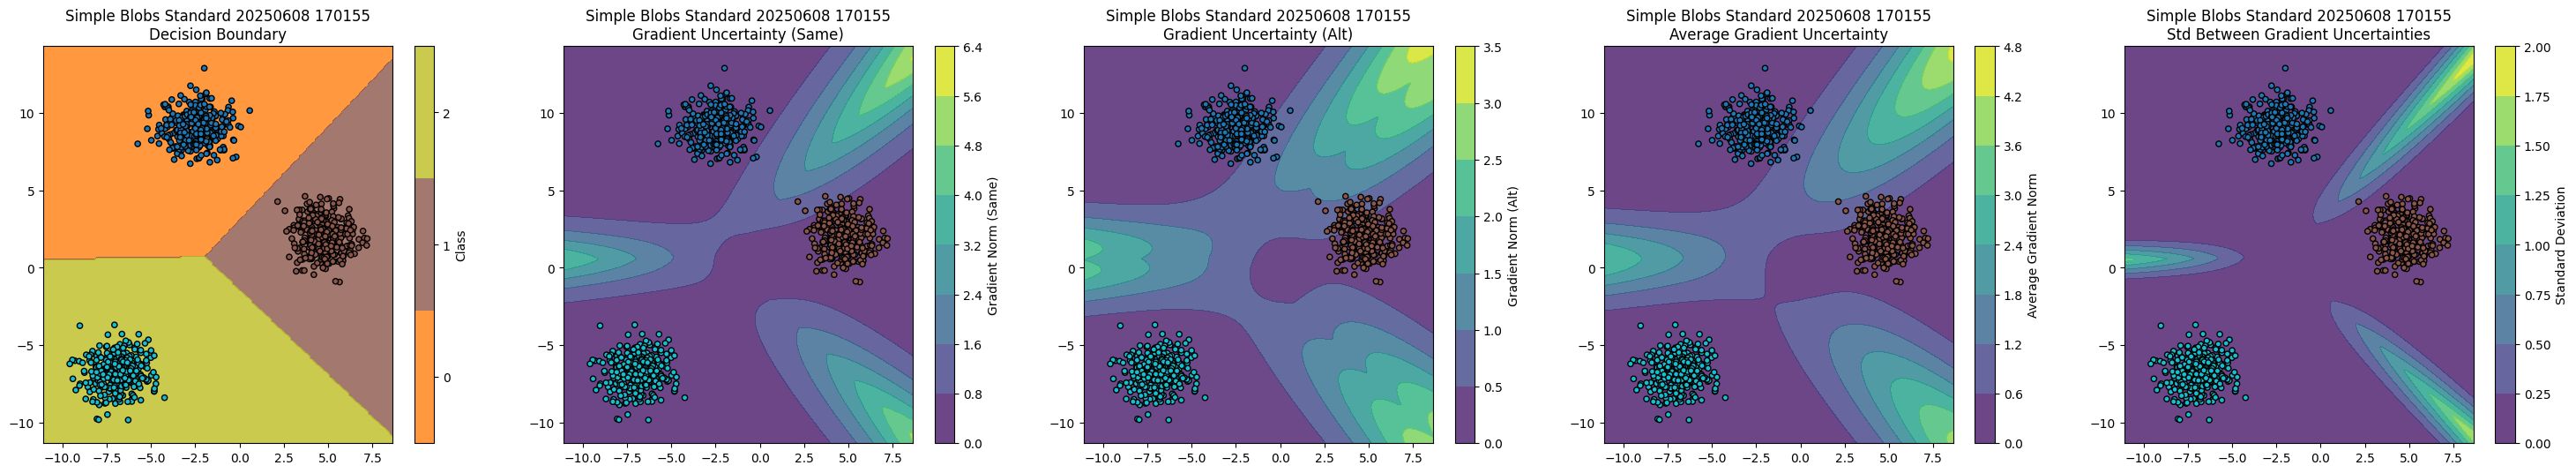

Experiment ID: simple_blobs_standard_20250608_170155
Experiment Type: standard
Accuracy: 1.0000
Average gradient uncertainty (same label): 0.8544
Average gradient uncertainty (alt labels): 0.7135
Average of gradient uncertainties: 0.7839
Average std between gradient uncertainties: 0.1495
Total plots saved: 5

EXPERIMENT SUMMARY

simple_blobs_standard_20250608_170155:
  Type: standard
  Accuracy: 1.0000

Total plots saved across all experiments: 5


In [ ]:
results, saved_files = visualize_saved_experiments(
    [exp1_id], save_plots=True, show_plots=True
)

In [ ]:
print("Experiment 2: Complex model on nonlinear (standard training)")
exp2_data = train_standard_model(
    X_nonlinear,
    y_nonlinear,
    ComplexModel,
    {"hidden_size": 32, "num_classes": num_classes},
    epochs=500,
)
exp2_id, exp_dir = saver.save_experiment(exp2_data, "complex_nonlinear_standard")

Experiment 2: Complex model on nonlinear (standard training)
Epoch [50/500], Loss: 0.2822
Epoch [100/500], Loss: 0.2306
Epoch [150/500], Loss: 0.1925
Epoch [200/500], Loss: 0.1794
Epoch [250/500], Loss: 0.1743
Epoch [300/500], Loss: 0.1711
Epoch [350/500], Loss: 0.1686
Epoch [400/500], Loss: 0.1670
Epoch [450/500], Loss: 0.1652
Epoch [500/500], Loss: 0.1637
Accuracy on entire dataset: 0.9240
Experiment saved as: complex_nonlinear_standard_20250608_170239
Directory: saved_experiments/multiclass/complex_nonlinear_standard_20250608_170239



Visualizing experiment: complex_nonlinear_standard_20250608_170239


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74758/3869687778.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))


Saving plots to: saved_experiments/multiclass/complex_nonlinear_standard_20250608_170239
Saved: decision_boundary.png
Saved: gradient_uncertainty_same.png
Saved: gradient_uncertainty_alt.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


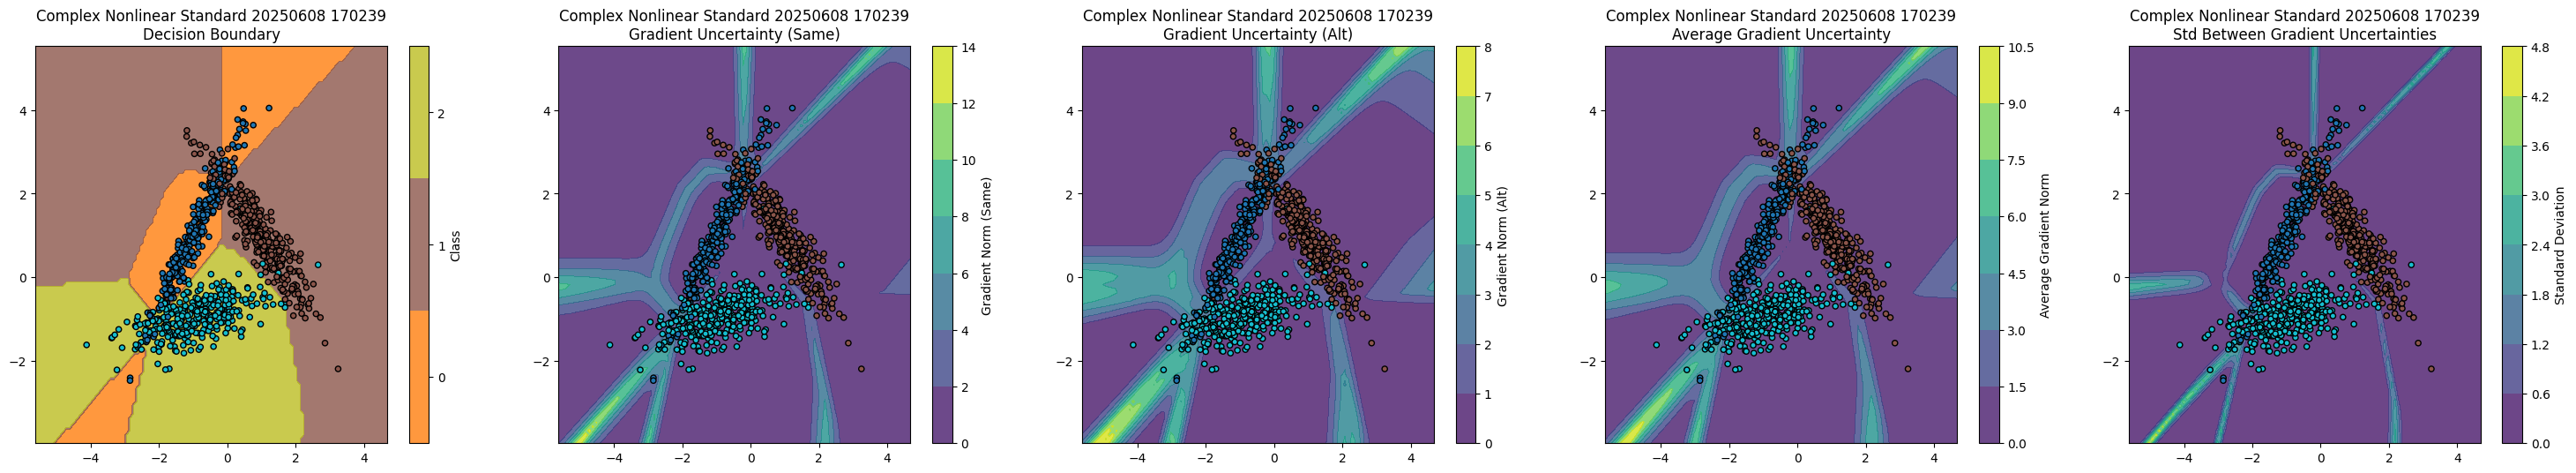

Experiment ID: complex_nonlinear_standard_20250608_170239
Experiment Type: standard
Accuracy: 0.9240
Average gradient uncertainty (same label): 1.0593
Average gradient uncertainty (alt labels): 0.9348
Average of gradient uncertainties: 0.9971
Average std between gradient uncertainties: 0.1817
Total plots saved: 5

EXPERIMENT SUMMARY

complex_nonlinear_standard_20250608_170239:
  Type: standard
  Accuracy: 0.9240

Total plots saved across all experiments: 5


In [ ]:
results, saved_files = visualize_saved_experiments(
    [exp2_id], save_plots=True, show_plots=True
)

In [ ]:
print("Experiment 3: Simple model on blobs (MCMC)")
exp3_data = train_mcmc_model(
    X_blobs,
    y_blobs,
    SimpleModel,
    {"num_classes": num_classes},
    prior_precision=0.01,
    num_samples=500,
    warmup_steps=100,
)
exp3_id, exp_dir = saver.save_experiment(exp3_data, "simple_blobs_mcmc")

Experiment 3: Simple model on blobs (MCMC)
Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 0.8277
Epoch [40/100], Loss: 0.2283
Epoch [60/100], Loss: 0.0920
Epoch [80/100], Loss: 0.0562
Epoch [100/100], Loss: 0.0410
Running NUTS MCMC sampler...


Sample: 100%|██████████| 600/600 [05:36,  1.78it/s, step size=6.45e-03, acc. prob=0.944]

Accuracy on entire dataset: 1.0000
Experiment saved as: simple_blobs_mcmc_20250608_173722
Directory: saved_experiments/multiclass/simple_blobs_mcmc_20250608_173722


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74758/3869687778.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))



Visualizing experiment: simple_blobs_mcmc_20250608_173722


Saving plots to: saved_experiments/multiclass/simple_blobs_mcmc_20250608_173722
Saved: decision_boundary.png
Saved: mcmc_uncertainty.png
Saved: gradient_uncertainty_same.png
Saved: gradient_uncertainty_alt.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


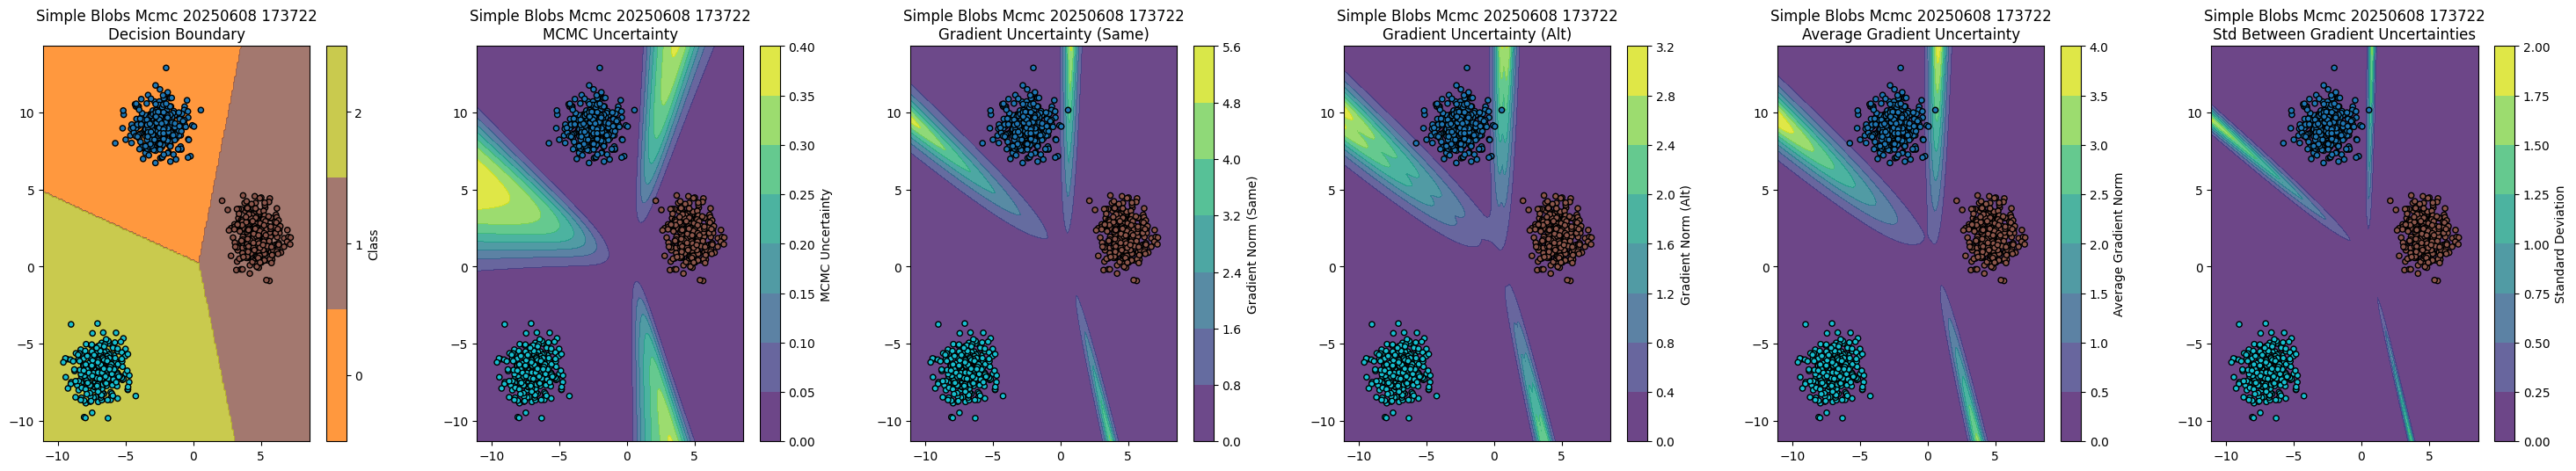

Saved: correlation_mcmc_grad_same.png
Saved: correlation_mcmc_grad_alt.png
Saved: correlation_mcmc_grad_avg.png
Saved: correlation_mcmc_grad_std.png
Correlation between MCMC Uncertainty and Gradient (Same): 0.1942
Correlation between MCMC Uncertainty and Gradient (Alt): 0.2353
Correlation between MCMC Uncertainty and Gradient (Avg): 0.2134
Correlation between MCMC Uncertainty and Gradient (Std): 0.1333


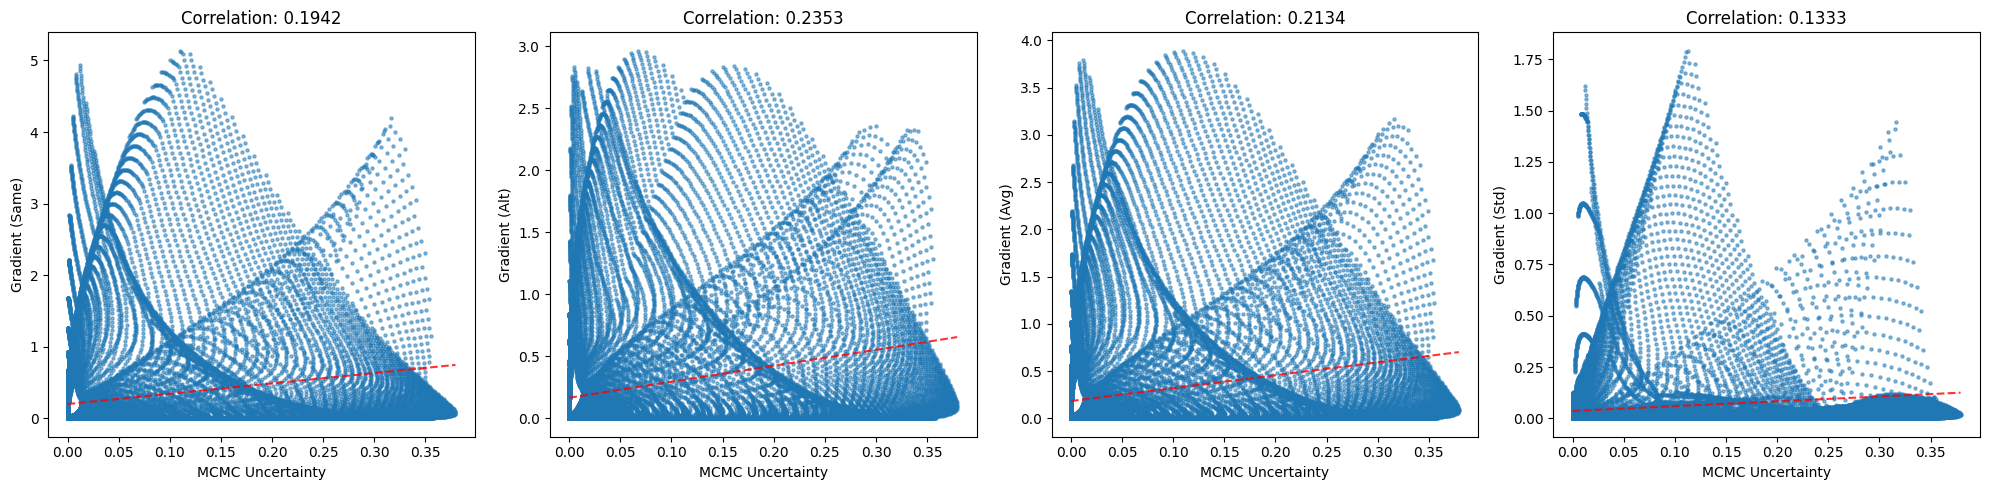

Experiment ID: simple_blobs_mcmc_20250608_173722
Experiment Type: mcmc
Accuracy: 1.0000
Average gradient uncertainty (same label): 0.2707
Average gradient uncertainty (alt labels): 0.2299
Average of gradient uncertainties: 0.2503
Average std between gradient uncertainties: 0.0475
Average MCMC uncertainty: 0.0492
corr_mcmc_grad_same: 0.1942
corr_mcmc_grad_alt: 0.2353
corr_mcmc_grad_avg: 0.2134
corr_mcmc_grad_std: 0.1333
Total plots saved: 10

EXPERIMENT SUMMARY

simple_blobs_mcmc_20250608_173722:
  Type: mcmc
  Accuracy: 1.0000
  MCMC-Gradient (Same): 0.1942
  MCMC-Gradient (Alt): 0.2353
  MCMC-Gradient (Avg): 0.2134
  MCMC-Gradient (Std): 0.1333

Total plots saved across all experiments: 10


In [ ]:
results, saved_files = visualize_saved_experiments(
    [exp3_id], save_plots=True, show_plots=True
)

In [ ]:
print("Experiment 4: Complex model on nonlinear (MCMC)")
exp4_data = train_mcmc_model(
    X_nonlinear,
    y_nonlinear,
    ComplexModel,
    {"hidden_size": 32, "num_classes": num_classes},
    prior_precision=0.001,
    num_samples=500,
    warmup_steps=100,
)
exp4_id, exp_dir = saver.save_experiment(exp4_data, "complex_nonlinear_mcmc")

Experiment 4: Complex model on nonlinear (MCMC)
Pre-training model for MCMC initialization...
Epoch [20/100], Loss: 0.3767
Epoch [40/100], Loss: 0.3000
Epoch [60/100], Loss: 0.2776
Epoch [80/100], Loss: 0.2622
Epoch [100/100], Loss: 0.2497
Running NUTS MCMC sampler...


Sample: 100%|██████████| 600/600 [09:01,  1.11it/s, step size=6.56e-03, acc. prob=0.311]

Accuracy on entire dataset: 0.8850
Experiment saved as: complex_nonlinear_mcmc_20250608_211244
Directory: saved_experiments/multiclass/complex_nonlinear_mcmc_20250608_211244


/var/folders/f5/0n6l0yh12yggft3np84h1xxr0000gn/T/ipykernel_74758/3869687778.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))



Visualizing experiment: complex_nonlinear_mcmc_20250608_211244
Saving plots to: saved_experiments/multiclass/complex_nonlinear_mcmc_20250608_211244
Saved: decision_boundary.png
Saved: mcmc_uncertainty.png
Saved: gradient_uncertainty_same.png
Saved: gradient_uncertainty_alt.png
Saved: gradient_uncertainty_avg.png
Saved: gradient_uncertainty_std.png


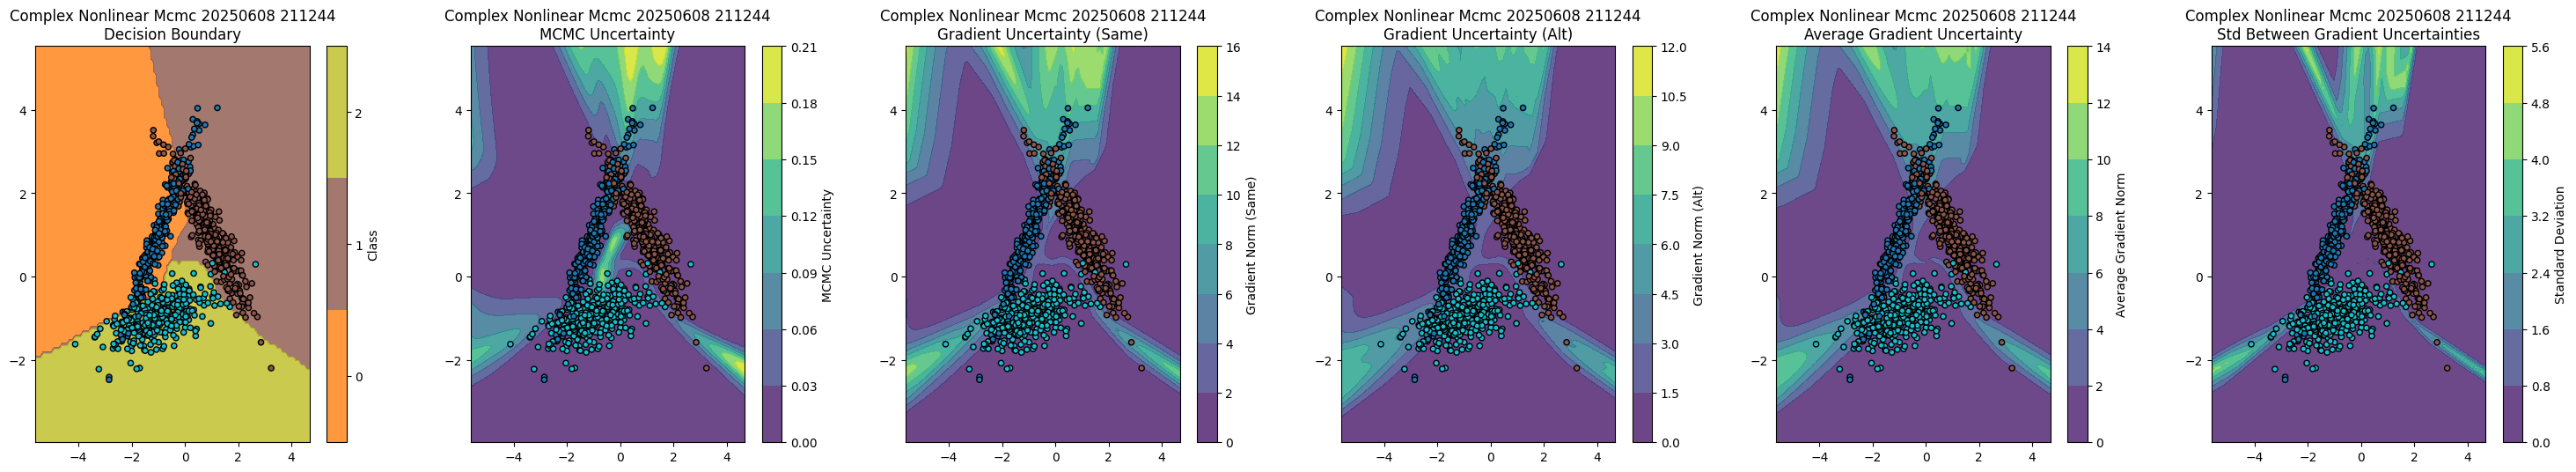

Saved: correlation_mcmc_grad_same.png
Saved: correlation_mcmc_grad_alt.png
Saved: correlation_mcmc_grad_avg.png
Saved: correlation_mcmc_grad_std.png
Correlation between MCMC Uncertainty and Gradient (Same): 0.8110
Correlation between MCMC Uncertainty and Gradient (Alt): 0.7419
Correlation between MCMC Uncertainty and Gradient (Avg): 0.7911
Correlation between MCMC Uncertainty and Gradient (Std): 0.7642


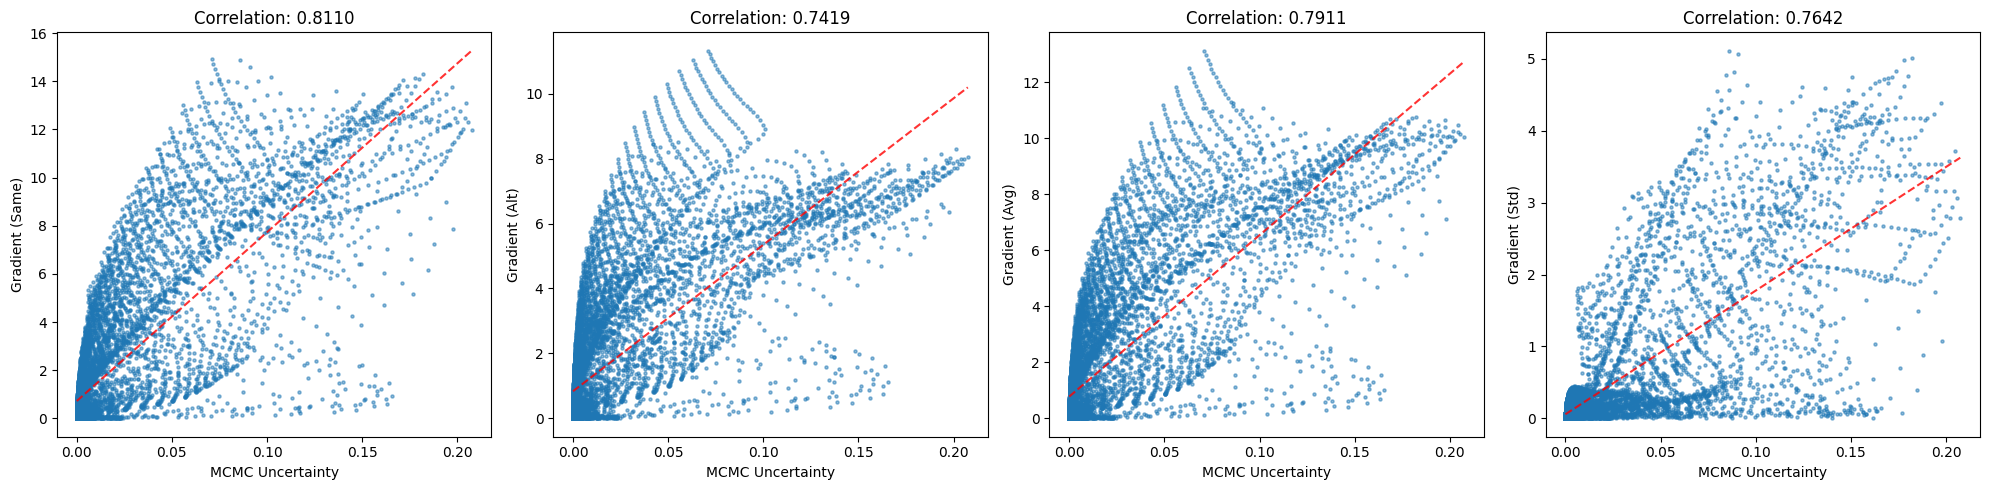

Experiment ID: complex_nonlinear_mcmc_20250608_211244
Experiment Type: mcmc
Accuracy: 0.8850
Average gradient uncertainty (same label): 2.2211
Average gradient uncertainty (alt labels): 1.8005
Average of gradient uncertainties: 2.0108
Average std between gradient uncertainties: 0.4249
Average MCMC uncertainty: 0.0214
corr_mcmc_grad_same: 0.8110
corr_mcmc_grad_alt: 0.7419
corr_mcmc_grad_avg: 0.7911
corr_mcmc_grad_std: 0.7642
Total plots saved: 10

EXPERIMENT SUMMARY

complex_nonlinear_mcmc_20250608_211244:
  Type: mcmc
  Accuracy: 0.8850
  MCMC-Gradient (Same): 0.8110
  MCMC-Gradient (Alt): 0.7419
  MCMC-Gradient (Avg): 0.7911
  MCMC-Gradient (Std): 0.7642

Total plots saved across all experiments: 10


In [ ]:
results, saved_files = visualize_saved_experiments(
    [exp4_id], save_plots=True, show_plots=True
)